# A Sequence Modeling Pipeline for Weather Prediction

In this task, you are to follow a pipeline for training a recurrent network.

--All the codes are written by me--

## 1 Import Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 2 Dataset

We will use the hourly temperature data for Basel (why Basel? because it was freely available) from [meteoblue](https://www.meteoblue.com/en/weather/archive/export/basel_switzerland_2661604?daterange=2021-06-01%20-%202021-06-23&domain=NEMSAUTO&params%5B%5D=temp2m&min=2021-06-16&max=2021-06-23&utc_offset=2&timeResolution=hourly&temperatureunit=CELSIUS&velocityunit=KILOMETER_PER_HOUR&energyunit=watts&lengthunit=metric&degree_day_type=10%3B30&gddBase=10&gddLimit=30) between 1 June 2021 and 23 June 2021. Here is a description of how you should prepare your dataset from this raw file:

* Raw data is available [here](https://ceng.metu.edu.tr/~skalkan/DL/Basel_weather.xlsx) as an XLSX file which was downloaded from [meteoblue](https://www.meteoblue.com/en/weather/archive/export/basel_switzerland_2661604?daterange=2021-06-01%20-%202021-06-23&domain=NEMSAUTO&params%5B%5D=temp2m&min=2021-06-16&max=2021-06-23&utc_offset=2&timeResolution=hourly&temperatureunit=CELSIUS&velocityunit=KILOMETER_PER_HOUR&energyunit=watts&lengthunit=metric&degree_day_type=10%3B30&gddBase=10&gddLimit=30).

* Load the file into Python as a NumPy array using [Pandas](https://pp4e-book.github.io/chapters/ch10_scientific_libraries.html#data-handling-analysis-with-pandas). Filter out unnecessary information at the top and convert the first column to an hour index, starting at 0 and finishing at 551.

* Split the data into two: A training set from the values between 1 June 2021 and 16 June 2021 (inclusive). A test set from the remaining values.

* For each set, slide a time window of six hours and with a stride of 1, and for each position of the window, create a training input-output pair as follows:

  $(\mathbf{x}_i = <T_i, T_{i+1}, T_{i+2}, T_{i+3}, T_{i+4}>, y_i = T_{i+5}),$
 
  where $T_i$ is the temperature at hour index $i$. 


In [3]:
df = pd.read_csv('data.csv') 

#clearing the unnecessary info
df = df[9:]
df = df.reset_index()
del df['index'] 

#adjusting date and checking if there is null value
df['location'] = pd.to_datetime(df['location'], format='%Y%m%dT%H')
df.rename(columns = {'location':'date'}, inplace = True)
df.isnull().sum()
df.head()

,date,Basel
0,2021-06-01 00:00:00,13.350529
1,2021-06-01 01:00:00,12.360529
2,2021-06-01 02:00:00,11.670529
3,2021-06-01 03:00:00,10.880529
4,2021-06-01 04:00:00,10.080529


In [4]:
#converting temperature texts to numeric value
lst1 = [float(i) for i in df['Basel']]

df['Basel'] = lst1
df

,date,Basel
0,2021-06-01 00:00:00,13.350529
1,2021-06-01 01:00:00,12.360529
2,2021-06-01 02:00:00,11.670529
3,2021-06-01 03:00:00,10.880529
4,2021-06-01 04:00:00,10.080529
...,...,...
547,2021-06-23 19:00:00,20.850529
548,2021-06-23 20:00:00,18.860529
549,2021-06-23 21:00:00,17.820530
550,2021-06-23 22:00:00,17.190529


In [5]:
inx = np.argmax(df['date'] == '2021-06-17 00:00:00') #locating index that corresponds to determined time

training = df.iloc[:inx] #splitting datasets
test = df.iloc[inx:]

test = test.reset_index() #index resetting for better understanding
del test['index'] 

In [6]:
# data preparation for lstm model
def prepare(dataset, w_size):
    x = []
    y = []
    
    for i in range(len(dataset)-w_size):
        x.append(np.array(dataset[i:i+w_size]))  # sequence data for inputs

        y.append(np.array(dataset[i+w_size])) # target data for backprop
        
    return np.array(x), np.array(y)

In [7]:
x_train, y_train = prepare(training.Basel, 5)
x_test, y_test = prepare(test.Basel, 5)

In [8]:
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError

model = Sequential()
model.add(LSTM(64, input_shape=(5,1,), return_sequences=False))
model.add(Dense(1))

model.compile(loss='mae', optimizer=Adam(learning_rate=0.01), metrics = RootMeanSquaredError())
model.fit(x_train, y_train, epochs=50, batch_size=10, validation_data=(x_test, y_test), verbose=1)

Epoch 1/50
38/38 [==============================] - 3s 20ms/step - loss: 10.1480 - root_mean_squared_error: 12.1747 - val_loss: 4.7853 - val_root_mean_squared_error: 6.1829
Epoch 2/50
38/38 [==============================] - 0s 5ms/step - loss: 3.7837 - root_mean_squared_error: 4.4844 - val_loss: 4.8811 - val_root_mean_squared_error: 6.2861
Epoch 3/50
38/38 [==============================] - 0s 4ms/step - loss: 3.5124 - root_mean_squared_error: 4.2728 - val_loss: 4.0281 - val_root_mean_squared_error: 5.3089
Epoch 4/50
38/38 [==============================] - 0s 4ms/step - loss: 2.5693 - root_mean_squared_error: 3.2749 - val_loss: 2.4984 - val_root_mean_squared_error: 3.3969
Epoch 5/50
38/38 [==============================] - 0s 4ms/step - loss: 1.5305 - root_mean_squared_error: 1.9402 - val_loss: 1.7640 - val_root_mean_squared_error: 2.3520
Epoch 6/50
38/38 [==============================] - 0s 5ms/step - loss: 1.1457 - root_mean_squared_error: 1.5015 - val_loss: 1.5226 - val_root_mean

## 7 Analyze the Results

### 7.1 Visualize the Loss Curve

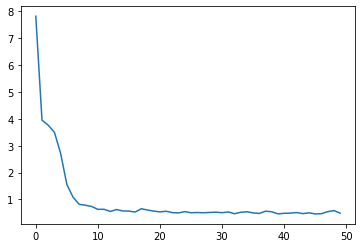

In [9]:
# Your implementation comes here
plt.plot(model.history.history['loss'])

### 7.2 Quantitative Analysis

Provide a quantitative analysis of your model on the test set using root mean squared error.

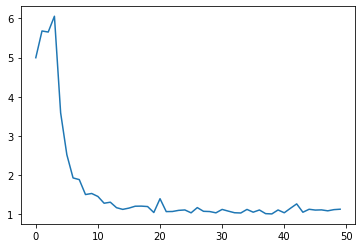

In [10]:
# Your implementation comes here
plt.plot(model.history.history['val_root_mean_squared_error'])
pass

### 7.3 Qualitative Analysis

Plot test data and your predictions over a sliding window. Plot two versions of your predictions: (i) Window sliding on the test data and you plot the predictions only. (ii) After obtaining the first prediction on the test data, window sliding over the predictions.

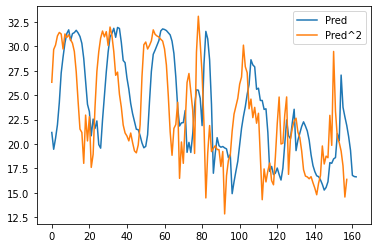

In [11]:
# Your implementation comes here
pred = model(x_test)

#plt.plot(y_test)
plt.plot(pred)

#plt.show()
xx, yy = prepare(pred, 5)
pred2 = model(xx)
plt.plot(pred2)
plt.legend(['Pred', 'Pred^2'])

## 8 Tune Your Model

Tune the following aspects for your model and provide a figure or a table in each case:

- Number of hidden neurons.
- Learning rate.
- Batch size.

Report the performance of the best model after tuning.

In [9]:
rates = [0.01, 0.001, 0.0001]
neurons = [32, 64, 128]
batch = [5,10,30]

dict = {'rate':[], 'neuron':[], 'bsize':[], 'train_loss': [], 'val_loss':[]}

for lr in rates:
    for neuron in neurons:
        for bsize in batch:
            
            model = Sequential()
            model.add(LSTM(neuron, input_shape=(5,1,), return_sequences=False))
            model.add(Dense(1))

            model.compile(loss='mae', optimizer=Adam(learning_rate=lr), metrics = RootMeanSquaredError())
            model.fit(x_train, y_train, epochs=30, batch_size=bsize, validation_data=(x_test, y_test), verbose=0)

            #for overall dataframe, storing the corresponding values
            dict['rate'].append(lr)
            dict['neuron'].append(neuron)
            dict['bsize'].append(bsize)
            dict['train_loss'].append(model.history.history['loss'][-1])
            dict['val_loss'].append(model.history.history['val_loss'][-1])

In [10]:
dff = pd.DataFrame(dict)
df2 = dff.sort_values('val_loss')
asd = df2[(df2['train_loss'] < .6) & (df2['val_loss'] < .8)]
asd = asd.reset_index()
del asd['index']
asd

,rate,neuron,bsize,train_loss,val_loss
0,0.010,64,10,0.542324,0.725196
1,0.001,128,5,0.494300,0.765452
2,0.010,32,10,0.582648,0.768534
3,0.010,32,5,0.537445,0.775467
4,0.010,64,5,0.553144,0.795534
